# Homework 5: Sentence-level Sentiment Classiﬁcation with PyTorch

## Evan James Heetderks / 高修杰 / 2019280025

In [12]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText

In [2]:
# Set up fields
TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)

# Make splits for data
train, val, test = datasets.SST.splits(TEXT, LABEL, fine_grained=True, train_subtrees=False)

# Build the vocabulary
TEXT.build_vocab(train, vectors=Vectors(name='vector.txt', cache='./data'))
LABEL.build_vocab(train)

# Make iterator for splits
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=64)

# Get pretrained embeddings, dimensions, and training parameters
pretrained_embeddings = TEXT.vocab.vectors
input_dim = len(TEXT.vocab)
emb_dim = pretrained_embeddings.shape[1]
train_iterations = len(train_iter)
val_iterations = len(val_iter)

In [3]:
#Define network architecture
class net(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded)
        output = torch.nn.functional.dropout(output, p=0.5)
        return self.fc(output[-1])

In [4]:
# Hyperparameters
num_layers = 2
hidden_dim = 768
output_dim = 5
num_epochs = 50
learning_rate = 0.0001
disp_freq = 20

In [5]:
# Define model, optimizer, and criterion
model = net(input_dim, emb_dim, hidden_dim, output_dim, num_layers)
model.embedding.weight.data.copy_(pretrained_embeddings)
opitmizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [6]:
# Training
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []
for epoch in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_iter):
        label = batch.label.sub(1)
        opitmizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        
        # Process training loss
        loss = criterion(predictions, label)
        training_loss.append(loss.item())
        
        # Process training accuracy
        correct = (predictions.argmax(dim=1) == label).float()
        accuracy = correct.sum()/len(correct)
        training_accuracy.append(accuracy.item())
        
        loss.backward()
        opitmizer.step()
        if (i+1) % disp_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, i+1, train_iterations, loss.item(), accuracy.item()))
    
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch in val_iter:
            label = batch.label.sub(1)
            predictions = model(batch.text.squeeze(1))
            
            # Process validation loss
            loss = criterion(predictions, label)
            validation_loss.append(loss.item())
            epoch_loss = epoch_loss + loss
            
            # Process validation accuracy
            correct = (predictions.argmax(dim=1) == label).float()
            accuracy = correct.sum()/len(correct)
            validation_accuracy.append(accuracy.item())
            epoch_accuracy = epoch_accuracy + accuracy
            
    print("**********************************************************************************************************")        
    print ('VALIDATION FOR EPOCH {}/{} --> Average Loss: {:.4f}, Average Accuracy: {:.4f}'.format(epoch+1, num_epochs, epoch_loss/val_iterations, epoch_accuracy/val_iterations))
    print("**********************************************************************************************************")

Epoch [1/50], Step [20/134], Loss: 1.6012, Accuracy: 0.2344
Epoch [1/50], Step [40/134], Loss: 1.6420, Accuracy: 0.2188
Epoch [1/50], Step [60/134], Loss: 1.5440, Accuracy: 0.3281
Epoch [1/50], Step [80/134], Loss: 1.5518, Accuracy: 0.2812
Epoch [1/50], Step [100/134], Loss: 1.6996, Accuracy: 0.2188
Epoch [1/50], Step [120/134], Loss: 1.5511, Accuracy: 0.3125
**********************************************************************************************************
VALIDATION FOR EPOCH 1/50 --> Average Loss: 1.5867, Average Accuracy: 0.2524
**********************************************************************************************************
Epoch [2/50], Step [20/134], Loss: 1.5721, Accuracy: 0.2344
Epoch [2/50], Step [40/134], Loss: 1.6020, Accuracy: 0.1719
Epoch [2/50], Step [60/134], Loss: 1.5530, Accuracy: 0.3281
Epoch [2/50], Step [80/134], Loss: 1.6011, Accuracy: 0.3281
Epoch [2/50], Step [100/134], Loss: 1.5985, Accuracy: 0.2188
Epoch [2/50], Step [120/134], Loss: 1.5099, Ac

**********************************************************************************************************
VALIDATION FOR EPOCH 13/50 --> Average Loss: 1.4799, Average Accuracy: 0.3886
**********************************************************************************************************
Epoch [14/50], Step [20/134], Loss: 0.7081, Accuracy: 0.7656
Epoch [14/50], Step [40/134], Loss: 0.6348, Accuracy: 0.7656
Epoch [14/50], Step [60/134], Loss: 0.7013, Accuracy: 0.7500
Epoch [14/50], Step [80/134], Loss: 0.6478, Accuracy: 0.7812
Epoch [14/50], Step [100/134], Loss: 0.8846, Accuracy: 0.6250
Epoch [14/50], Step [120/134], Loss: 0.8245, Accuracy: 0.6406
**********************************************************************************************************
VALIDATION FOR EPOCH 14/50 --> Average Loss: 1.4429, Average Accuracy: 0.3956
**********************************************************************************************************
Epoch [15/50], Step [20/134], Loss: 0.5973, Accu

Epoch [26/50], Step [20/134], Loss: 0.2562, Accuracy: 0.9375
Epoch [26/50], Step [40/134], Loss: 0.4967, Accuracy: 0.8438
Epoch [26/50], Step [60/134], Loss: 0.2274, Accuracy: 0.9531
Epoch [26/50], Step [80/134], Loss: 0.3432, Accuracy: 0.9062
Epoch [26/50], Step [100/134], Loss: 0.4401, Accuracy: 0.8906
Epoch [26/50], Step [120/134], Loss: 0.5972, Accuracy: 0.7969
**********************************************************************************************************
VALIDATION FOR EPOCH 26/50 --> Average Loss: 1.8862, Average Accuracy: 0.3973
**********************************************************************************************************
Epoch [27/50], Step [20/134], Loss: 0.1809, Accuracy: 0.9688
Epoch [27/50], Step [40/134], Loss: 0.4078, Accuracy: 0.8594
Epoch [27/50], Step [60/134], Loss: 0.3444, Accuracy: 0.9062
Epoch [27/50], Step [80/134], Loss: 0.5114, Accuracy: 0.8438
Epoch [27/50], Step [100/134], Loss: 0.3842, Accuracy: 0.8906
Epoch [27/50], Step [120/134], Los

Epoch [38/50], Step [120/134], Loss: 0.3656, Accuracy: 0.9062
**********************************************************************************************************
VALIDATION FOR EPOCH 38/50 --> Average Loss: 2.0214, Average Accuracy: 0.3894
**********************************************************************************************************
Epoch [39/50], Step [20/134], Loss: 0.2487, Accuracy: 0.9375
Epoch [39/50], Step [40/134], Loss: 0.3714, Accuracy: 0.9062
Epoch [39/50], Step [60/134], Loss: 0.1095, Accuracy: 0.9688
Epoch [39/50], Step [80/134], Loss: 0.1298, Accuracy: 1.0000
Epoch [39/50], Step [100/134], Loss: 0.1321, Accuracy: 0.9531
Epoch [39/50], Step [120/134], Loss: 0.2603, Accuracy: 0.9375
**********************************************************************************************************
VALIDATION FOR EPOCH 39/50 --> Average Loss: 2.0104, Average Accuracy: 0.3972
*********************************************************************************************

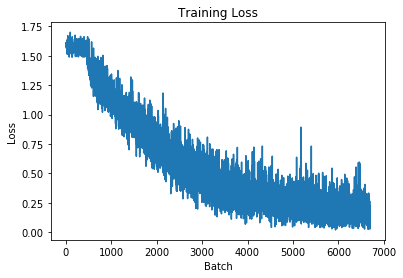

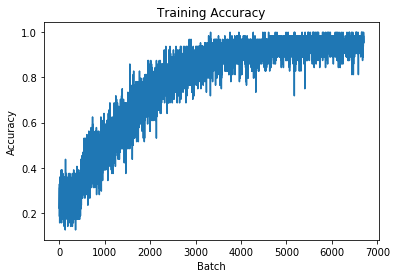

In [16]:
# Plot training loss and accuracy
fig = plt.figure()
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig = plt.figure()
plt.plot(training_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

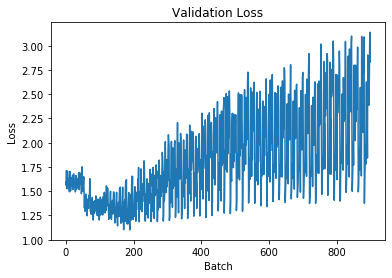

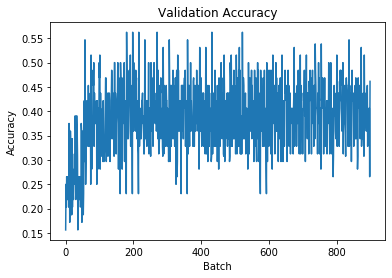

In [17]:
# Plot validation loss and accuracy
fig = plt.figure()
plt.plot(validation_loss)
plt.title("Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig = plt.figure()
plt.plot(validation_accuracy)
plt.title("Validation Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

In [10]:
# Testing
testing_loss = 0
testing_accuracy = 0
average_testing_loss = 0
average_testing_accuracy = 0
model.eval()
with torch.no_grad():
    for batch in test_iter:
        label = batch.label.sub(1)
        predictions = model(batch.text.squeeze(1))
        
        # Process testing loss
        loss = criterion(predictions, label)
        testing_loss = testing_loss + loss.item()
        
        # Process testing accuracy
        correct = (predictions.argmax(dim=1) == label).float()
        accuracy = correct.sum()/len(correct)
        testing_accuracy = testing_accuracy + accuracy.item()
        
        
    average_testing_loss = testing_loss/len(test_iter)
    average_testing_accuracy  = (testing_accuracy/len(test_iter))*100
    
print('Average testing loss: {:.4f}, Average testing accuracy: {:.2f}%'.format(average_testing_loss, average_testing_accuracy))

Average testing loss: 2.3808, Average testing accuracy: 37.07%
